In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import re, json, os, time, cv2, math

## 1. Visualization Utilities

### 1.1 Bounding Boxes Utilities
some functions are used to draw bounding boxes around the birds in the `image`.

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [2]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)
        
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

visualize the data and the model's predictions.

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [3]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
    
    n = len(images)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    for i in range(n):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bbox = pred_bboxes[i]
            bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0],
                    bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
            bboxes_to_plot.append(bbox)
        if (len(bboxes) > i):
            bbox = bboxes[i]
            if bboxes_normalized == True:
                bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], 
                        bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)
        img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), 
                                                         color=[(255,0,0), (0, 255, 0)])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_to_draw)
        
        if len(iou) > i:
            color = 'black'
            if (iou[i][0] < iou_threshold):
                color = 'red'
            ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
            
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## 2. Preprocess and load the dataset
### 2.1 preprocessing utilities

**read_image_tfds**
- resize the `image` to (224, 224)
- normalize the `image`
- translate and normalize the bounding boxes

In [4]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    # normalize the image from -1 to 1
    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [5]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- This function reads `image` from `data`
- It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [6]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
This function converts a `dataset` into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [7]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

#### dataset_to_numpy_with_original_bboxes_util

- This function converts a `dataset` into numpy arrays of 
  - original images
  - resized and normalized images
  - bounding boxes
- This will be used for plotting the original images with true and predicted bounding boxes.

In [8]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

<a name="2-2"></a>
### 2.2 Visualize the images and their bounding box labels
Now, take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.
- change `download` in **tfds.load** function as `True` when first time load it

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='./caltech_birds/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        

/var/folders/yh/_x7knk010_jf8mn6y34t0cnc0000gn/T/ipykernel_13821/766332155.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


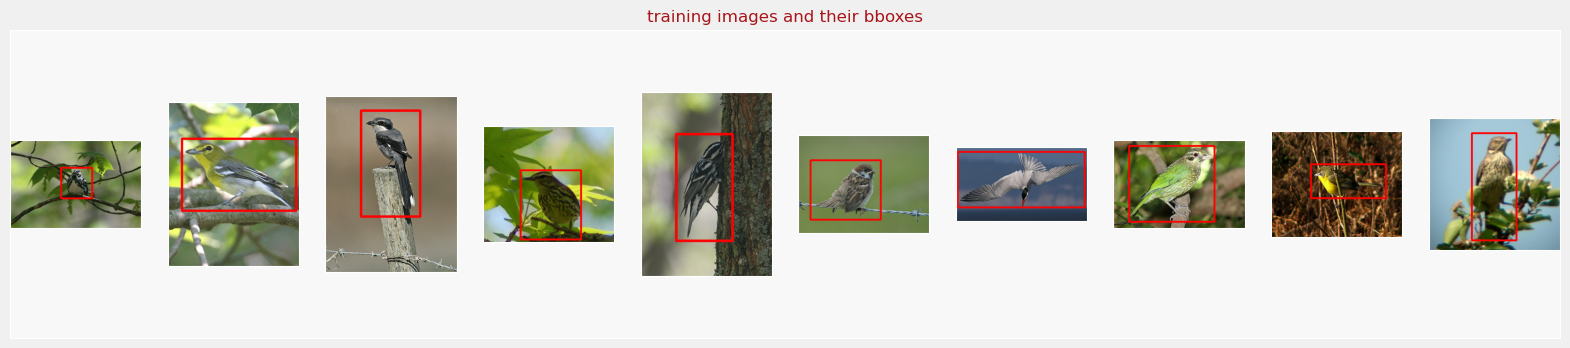

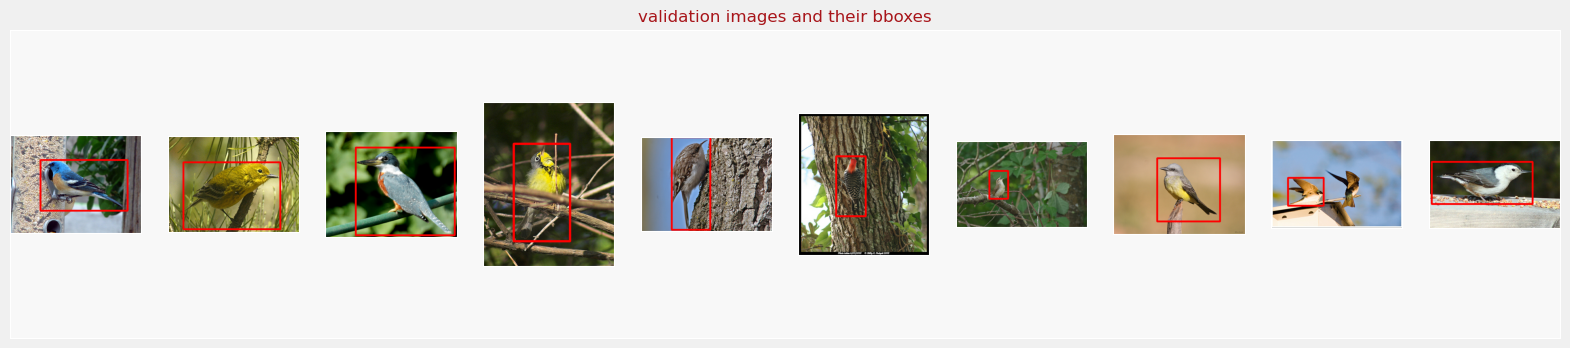

In [10]:

def get_visualization_training_dataset():      

    splits, info = tfds.load("caltech_birds2010", split=["train", "test"],
                             with_info=True, data_dir='./caltech_birds', download=False) 
    print(info)
    train_dataset, test_data_set = splits
    
    visualization_training_dataset = train_dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    visualization_test_dataset = test_data_set.map(read_image_tfds_with_original_bbox,
                                                  num_parallel_calls=16)
    
    return visualization_training_dataset, visualization_test_dataset


visualization_training_dataset, visualization_test_dataset = get_visualization_training_dataset()

(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), 
                          np.array(visualization_training_bboxes), np.array([]),
                          "training images and their bboxes")


(visualization_test_images, visualization_test_bboxes) = dataset_to_numpy_util(visualization_test_dataset, N=10)

display_digits_with_boxes(np.array(visualization_test_images), np.array([]), 
                          np.array(visualization_test_bboxes), np.array([]),
                          "validation images and their bboxes")

### example of drawing bounding box on an image

In [11]:
# the original dataset including the normalized bounding box
example_1 = next(iter(visualization_training_dataset))
print('the number of example_1 elements: ', len(example_1))
image = example_1[0]
bounding_box = example_1[1]
normalized_image, normalized_box = read_image_tfds(image, bounding_box)
print('image shape (y, x, channel): ', str(image.shape))
print('bouding box (xmin, ymin, xmax, ymax): ', str(bounding_box.numpy()))
print('normalized bounding box', [x.numpy() for x in normalized_box])

the number of example_1 elements:  2
image shape (y, x, channel):  (333, 500, 3)
bouding box (xmin, ymin, xmax, ymax):  [ 55.  88. 386. 332.]
normalized bounding box [0.11000001, 0.2642643, 0.772, 0.996997]


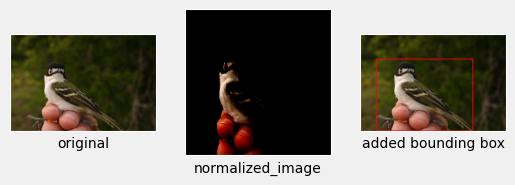

In [12]:
image_array = image.numpy() # transfer image to numpy array
xmin, ymin, xmax, ymax = bounding_box.numpy()

cv2.rectangle(image_array, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.yticks([])
plt.xticks([])
plt.xlabel('original')
plt.imshow(image)
ax = fig.add_subplot(1, 3, 2)
plt.imshow(normalized_image)
plt.yticks([])
plt.xticks([])
plt.xlabel('normalized_image')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(image_array)
plt.yticks([])
plt.xticks([])
plt.xlabel('added bounding box')
plt.show()

In [13]:
BATCH_SIZE = 64

def get_batch_dataset():
    
    training_batches = visualization_training_dataset.map(read_image_tfds, num_parallel_calls=16)
    training_batches = training_batches.shuffle(512, reshuffle_each_iteration=True).repeat().batch(BATCH_SIZE)
    training_batches = training_batches.prefetch(-1)
    
    test_batches = visualization_test_dataset.map(read_image_tfds, num_parallel_calls=16)
    test_batches = test_batches.batch(BATCH_SIZE).repeat()
    
    return training_batches, test_batches

training_batches, test_batches = get_batch_dataset()

## 3. Define the network
Bounding box prediction is treated as a "regression" task, in that you want the model to output numerical values.

- You will be performing transfer learning with **MobileNet V2**.  The model architecture is available in TensorFlow Keras.
- You'll also use pretrained `'imagenet'` weights as a starting point for further training.  These weights are also readily available 
- You will choose to retrain all layers of **MobileNet V2** along with the final classification layers.

**Note:** For the following exercises, please use the TensorFlow Keras Functional API (as opposed to the Sequential API).

In [20]:
def feature_extractor(inputs):
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                    include_top=False,
                                                                    weights='imagenet')
    feature_extractor_output = mobilenet_model(inputs)
    return feature_extractor_output

In [15]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, 'relu')(x)
    x = tf.keras.layers.Dense(512, 'relu')(x)
    
    return x

In [16]:
def bounding_box_regression(x):
    bounding_box_regreession_output = tf.keras.layers.Dense(4, name='bounding_box')(x)
    
    return bounding_box_regreession_output

In [17]:
def final_model(inputs):
    feature_extractor_output = feature_extractor(inputs)
    dense_output = dense_layers(feature_extractor_output)
    bounding_output = bounding_box_regression(dense_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=bounding_output)
    
    return model

In [21]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    model = final_model(inputs)
    model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(momentum=0.9), metrics=['mse'])
    
    return model

In [22]:
model = define_and_compile_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [23]:
EPOCH = 50

BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(list(visualization_training_dataset))

# Get the length of the validation set
length_of_test_dataset = len(list(visualization_test_dataset))

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

# get the validation steps (per epoch) (may be a few lines of code)
test_steps = length_of_test_dataset//BATCH_SIZE
if length_of_test_dataset % BATCH_SIZE > 0:
    test_steps += 1
    
### END CODE HERE

### either fit the model or use the saved model from birds.h5

In [24]:
# history = model.fit(training_batches, epochs=EPOCH, validation_data=test_batches,
#                    steps_per_epoch=steps_per_epoch, validation_steps=test_steps,batch_size = BATCH_SIZE
#                    )

model = tf.keras.models.load_model('birds.h5')

In [25]:
loss = model.evaluate(test_batches, steps=test_steps)

2022-10-08 14:42:33.983414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 10s 183ms/step - loss: 0.0180 - mse: 0.0180


In [26]:
# save model
# model.save("birds.h5")

## 4. Plot Loss Function and visualize the result


In [28]:
# plot the loss metrics.
# plot_metrics("loss", "Bounding Box Loss")

In [29]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_test_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/var/folders/yh/_x7knk010_jf8mn6y34t0cnc0000gn/T/ipykernel_13821/1115781327.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)
2022-10-08 14:45:36.890054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 99ms/step
Number of predictions where iou > threshold(0.5): 245
Number of predictions where iou < threshold(0.5): 255


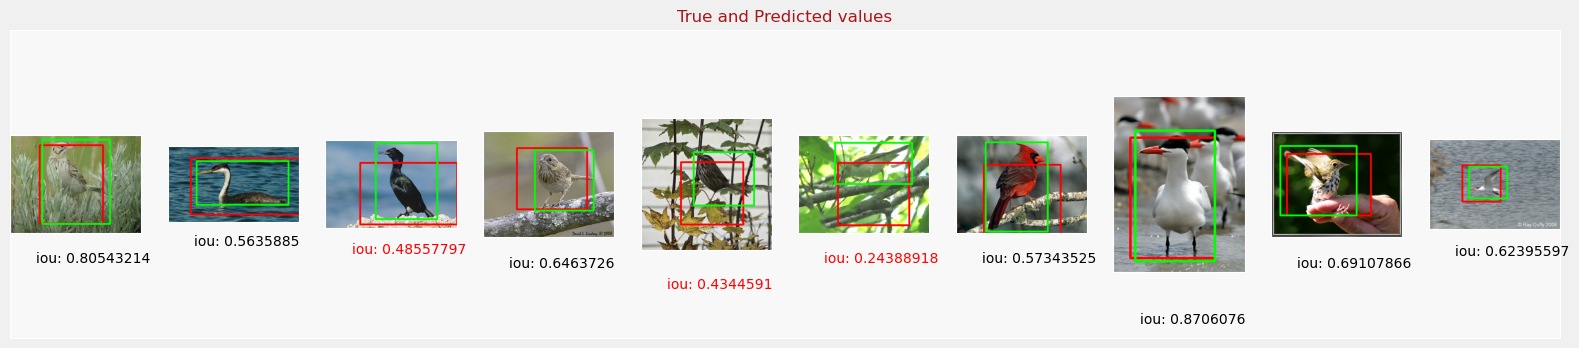

In [32]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes],
                          normalized_bboxes[indexes], iou[indexes],
                          "True and Predicted values", bboxes_normalized=True)